In [102]:
# implementing a stacking example 
# base estimators - LogisticRegression, KNN
# meta-estimator - Single DecisionTree

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.base import clone, BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor


In [36]:
df = pd.read_csv('train_kaggle.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [149]:
df.iloc[:,:-1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


## 1. Мы видим, что атрибутов достаточно много, есть как категориальные, так и числовые.

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 2. Есть много атрибутов, в которых не заполнены значения. Если делать это качественно, то можно поиграться с работой с пропусками, но т.к. задача работы - сделать стэкинг, то выберем парочку полных атрибутов, чтобы не сильно с ними возиться.

In [81]:
categoricals = ['MSZoning','LandContour','Utilities','Neighborhood','Foundation']
continious = ['OverallQual','TotRmsAbvGrd']
target = 'SalePrice'

In [83]:
total = 0
for cat in categoricals:
    total += len(df[cat].unique())
    print(cat,len(df[cat].unique()))
print('Total:',total)

MSZoning 5
LandContour 4
Utilities 2
Neighborhood 25
Foundation 6
Total: 42


### Для ванхот энкодинга всё более менее ок

In [86]:
X = pd.concat([df[continious],pd.get_dummies(df[categoricals])],axis=1)
y = df[target]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   OverallQual           1460 non-null   int64
 1   TotRmsAbvGrd          1460 non-null   int64
 2   MSZoning_C (all)      1460 non-null   uint8
 3   MSZoning_FV           1460 non-null   uint8
 4   MSZoning_RH           1460 non-null   uint8
 5   MSZoning_RL           1460 non-null   uint8
 6   MSZoning_RM           1460 non-null   uint8
 7   LandContour_Bnk       1460 non-null   uint8
 8   LandContour_HLS       1460 non-null   uint8
 9   LandContour_Low       1460 non-null   uint8
 10  LandContour_Lvl       1460 non-null   uint8
 11  Utilities_AllPub      1460 non-null   uint8
 12  Utilities_NoSeWa      1460 non-null   uint8
 13  Neighborhood_Blmngtn  1460 non-null   uint8
 14  Neighborhood_Blueste  1460 non-null   uint8
 15  Neighborhood_BrDale   1460 non-null   uint8
 16  Neighb

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [175]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=5)
cross_val_score(regressor, X_train, y_train, cv=10)
regressor.fit( X_train, y_train )

DecisionTreeRegressor(max_depth=5, random_state=0)

In [176]:
import graphviz 
dot_data = tree.export_graphviz(regressor, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

'iris.pdf'

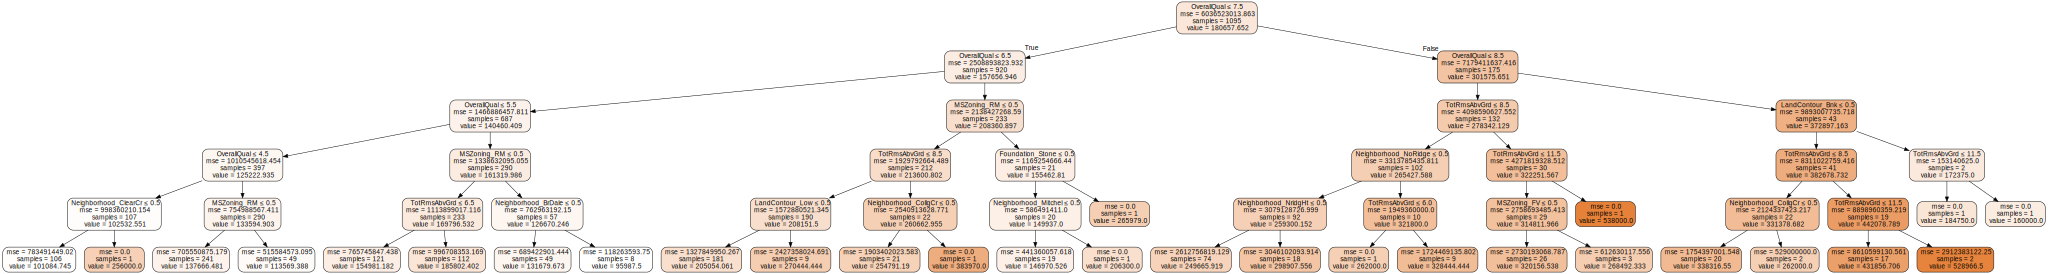

In [177]:
dot_data = tree.export_graphviz(regressor, out_file=None, 
                      feature_names=X_train.columns,  
                        
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Напишем класс стекинга, который будет получать на вход сколько угодно регрессоров. каждый из регрессоров будет обучасть с кросс валидацией  (10 фолдов). После чего мета регрессор (дерево) построит прогноз по прогнозам моделей на входе.

In [137]:
class StackingRegressor(BaseEstimator, TransformerMixin, RegressorMixin):
    
    def __init__(self, regressors):
        self.regressors = regressors
        self.meta_regressor = DecisionTreeRegressor()
    
    def fit(self, X, y):
        for rg in self.regressors:
            #rg.fit(X, y)
            cross_val_score(rg, X, y, cv=10)
            
        
        self.meta_regressor.fit(self._get_meta_features(X), y)
        return self
    
    def _get_meta_features(self, X):
        probas = np.asarray([
            rg.predict(X) for rg in self.regressors
        ])
        return (np.vstack(probas).T)
    
    def predict(self, X):
        return self.meta_regressor.predict(self._get_meta_features(X))
    
    #def predict_proba(self, X):
        #return self.meta_regressor.predict_proba(self._get_meta_features(X))

In [53]:
# X, y = make_regression(
#     n_samples=1000, n_features=50,n_informative=30,
#      random_state=11
# )

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [90]:
y_train[:5]

86      174000
1085    147000
1049     84900
260     176000
1073    159500
Name: SalePrice, dtype: int64

## Посмотрим, что покажет из коробки линейная регрессия и КНН

In [138]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('LinearRegression coefficient of determination R^2: ', lr.score(X_test, y_test))

LinearRegression coefficient of determination R^2:  0.7185855767654578


In [139]:
knn = KNeighborsRegressor(n_neighbors=30)
knn.fit(X_train, y_train)
print('KNN coefficient of determination R^2: ', knn.score(X_test, y_test))

KNN coefficient of determination R^2:  0.7173277957802096


## Значения R^2 практически равны, между собой алгоритмы не отличаются. Попробуем их в стэкинге.

In [140]:
base_regressors = [lr, knn ]

In [132]:
stacking = StackingRegressor(base_regressors)
stacking.fit(X_train, y_train)
print('Stacking regressor coefficient of determination R^2: ', stacking.score(X_test, y_test))


Stacking regressor coefficient of determination R^2:  0.7695311925191131


## Как можно увидеть, стэкинг выдал результат значительно лучше, чем было по отдельности.
##    `Но что будет, если мы запустим какой-нибудь "мощный" алгоритм обучения - градиентний бустинг`

In [133]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
print('GradientBoostingRegressor coefficient of determination R^2: ', gbr.score(X_test, y_test))

GradientBoostingRegressor coefficient of determination R^2:  0.8155496316000941


## Мы увидим, что модель обучилась лучше, чем стэкинг двух простых моделей. Попробуем и её добавить в стекинг

In [134]:
base_regressors = [lr, knn, gbr ]

In [135]:
stacking = StackingRegressor(base_regressors)
stacking.fit(X_train, y_train)
print('Stacking regressor coefficient of determination R^2: ', stacking.score(X_test, y_test))


Stacking regressor coefficient of determination R^2:  0.771293068835791


## Добавление в стекинг улучшило результат, но градиентный бустинг отдельно показал результат куда лучше. 
моя гипотеза в этом следующая:
Т.к. у нас есть 2 слабых алгоритма и 1 сильный, то когда в листах мета регрессора усредняются значения предсказаний, то получается что-то среднее, между 2*плохо и хорошо, получается не очень. что мы и видим, 0,77<0.81